### using membrane simulation - updated for non-zero z0 and simplified membrane

In [ ]:
import jax
import jax.numpy as jnp
from jax import random, vmap, jit, grad, value_and_grad

from diffrax import diffeqsolve, ODETerm, SaveAt, Tsit5

import matplotlib.pyplot as plt
from tqdm import trange
from functools import partial
import copy

from membrane_simulation import obtain_ph_plane, obtain_qoi_plane, plot_membrane_shape
from membrane_simulation import _MU_elastic, _MU_stiff, _JM_elastic, _JM_stiff

In [2]:
# try using functions to simulate a valve
h = 0.001 # thickness


PP, heights, best_x = obtain_ph_plane(h, 'elast',
                                   p_min=0.1, p_max=10_000,
                                   dx_init=0.04, init_guess=5.5, max_iter=400,
                                   return_best_x=True,)


# def obtain_ph_plane(h, material_type,
#             p_min=50, p_max=8_000, num_ps=100,
#             init_guess=5, dx_init=0.01, atol=1e-4, max_iter=500,
#             verbose=True, filter_negative=True, min_height=1e-3,
#             return_best_x=False):

100%|██████████| 400/400 [01:05<00:00,  6.09it/s]


Loop finished after 400 iterations, but tolerance has not been reached yet for some points.
Overall, 0 pressure/force pairs were successfull.
Could not find roots for the remaining 100.

Computing heights for successfull pressure/force pairs...
Found 0 heights larger than 1mm. Other 0 were less than that.


while the above code runs - it doesn't actually solve. will attempt to use an intial, simpler version for our simple task:

In [7]:
R0 = 0.0254 # contact area
RF = 0.07 # width of the disk
borders = (R0, RF) # only contains R0 and RF for 0 rings
mat_constants = ('elast',)

FF, PP, heights, best_x = obtain_qoi_plane(h, borders, mat_constants,
                                   F_min=0, F_max=30,
                                   p_min=10, p_max=4_000,
                                   dx_init=0.04, init_guess=5.5, max_iter=200,
                                   return_best_x=True,
                                   atol=0.001)

100%|██████████| 200/200 [11:41<00:00,  3.51s/it]

Loop finished after 200 iterations, but tolerance has not been reached yet for some points.
Overall, 0 pressure/force pairs were successfull.
Could not find roots for the remaining 10000.

Computing heights for successfull pressure/force pairs...


Found 0 heights larger than 1mm. Other 0 were less than that.


In [8]:
# try using existing function for our valve (imagine it starts from plane):
R0 = 1e-9 # contact area
RF = 3.5e-3 # width of the disk
borders = (R0, RF) # only contains R0 and RF for 0 rings
mat_constants = ('elast',)

FF, PP, heights, best_x = obtain_qoi_plane(h, borders, mat_constants,
                                   F_min=0, F_max=0, num_Fs=1,
                                   p_min=10, p_max=4_000,
                                   dx_init=0.04, init_guess=5.5, max_iter=200,
                                   return_best_x=True,
                                   atol=0.001)

100%|██████████| 200/200 [00:23<00:00,  8.51it/s]


Loop finished after 200 iterations, but tolerance has not been reached yet for some points.
Overall, 0 pressure/force pairs were successfull.
Could not find roots for the remaining 100.

Computing heights for successfull pressure/force pairs...
Found 0 heights larger than 1mm. Other 0 were less than that.


## Rolled-back simulation

In [85]:
# material constants
MU_elastic = 31_700
JM_elastic = 39.6

# other constants
H = 0.001 # thickness
R0 = 1e-3 # contact radius
RF = 3.75e-3 # width of the disk

# package everything together
mat_constants_elastic = (MU_elastic, JM_elastic, H)
mat_constants_stiff = (MU_stiff, JM_stiff, H)

### Doing our ODE

In [86]:
def W_fn(lamb_r, lamb_theta, constants):
    # unpack constants
    mu, Jm, h = constants
    
    # compute argument of log
    log_arg = 1 - (lamb_r**2 + lamb_theta**2 + 1/(lamb_r**2 * lamb_theta**2) - 3)/Jm
    
    return -mu*Jm*jnp.log(log_arg)/2

def W_grads(lamb_r, lamb_theta, constants):
    # funciton for computin gradient of W_fn
    def _grads(lamb_r, lamb_theta):
        W, (W_r, W_theta) = value_and_grad(W_fn, argnums=(0,1))(lamb_r, lamb_theta, constants=constants)
        return W_r, (W, W_theta)
    
    # now get other derivatives
    (W_r, (W, W_theta)), (W_rr, W_r_theta) =  value_and_grad(_grads, argnums=(0,1), has_aux=True)(lamb_r, lamb_theta)
    return W, W_r, W_theta, W_rr, W_r_theta

In [87]:
# test W_fn
W_fn(lamb_r=1.5, lamb_theta=1.7, constants=mat_constants_elastic), W_fn(lamb_r=1.1, lamb_theta=1.1, constants=mat_constants_stiff) 

(Array(37451.992, dtype=float32, weak_type=True),
 Array(54357.207, dtype=float32, weak_type=True))

In [88]:
# test W_grads
W_grads(lamb_r=1.5, lamb_theta=1.7, constants=mat_constants_elastic), W_grads(lamb_r=1.1, lamb_theta=1.1, constants=mat_constants_stiff)

((Array(37451.992, dtype=float32, weak_type=True),
  Array(47023.77, dtype=float32, weak_type=True),
  Array(54159.457, dtype=float32, weak_type=True),
  Array(44071.793, dtype=float32, weak_type=True),
  Array(8116.244, dtype=float32, weak_type=True)),
 (Array(54357.242, dtype=float32, weak_type=True),
  Array(534098.06, dtype=float32, weak_type=True),
  Array(534098.06, dtype=float32, weak_type=True),
  Array(3573266.5, dtype=float32, weak_type=True),
  Array(1829122.2, dtype=float32, weak_type=True)))

In [89]:
# this determines the evolution of the ODE system
def vector_field(r, y, args):
    # unpack y
    lamb_r, lamb_theta, beta = y
    # unpack constants
    mat_constants, p = args
    mu, Jm, h, = mat_constants

    # compute information about W (and derivatives)
    W, W_r, W_theta, W_rr, W_r_theta = W_grads(lamb_r, lamb_theta, mat_constants)
    
    d_lamb_r = (W_theta-lamb_r*W_r_theta)*jnp.sin(beta)/(r*W_rr) - (W_r - lamb_theta*W_r_theta)/(r*W_rr)
    d_lamb_theta = (lamb_r*jnp.sin(beta)-lamb_theta)/r
    d_beta = W_theta*jnp.cos(beta)/(r*W_r) - p * lamb_r*lamb_theta/(h*W_r)

    d_y = d_lamb_r, d_lamb_theta, d_beta
    return jnp.array(d_y)

#### Testing for elastic material

In [ ]:
# example
# set initial conditions + constants
x = 1.46
F = 0
p = 500
W, W_r, W_theta, W_rr, W_r_theta = W_grads(x, 1., mat_constants_elastic)
# beta_0 = jnp.arccos( (-F+jnp.pi * p * R0**2) / (2*jnp.pi*H*R0*W_r) )
beta_0 = 0
y0 = jnp.array([x, 1., beta_0])

# look at initial condition for ODE
y0

Array([1.46, 1.  , 0.  ], dtype=float32)

In [97]:
# evolving DOE
term = ODETerm(vector_field)
solver = Tsit5() # TODO this solver can probably be substituted w/ something faster (but less accurate)
r0 = R0
r1 = RF
dr0 = 0.0001
args = mat_constants_elastic, p
saveat = SaveAt(ts=jnp.linspace(r0, r1, 1000))
sol = diffeqsolve(term, solver, r0, r1, dr0, y0, args=args, saveat=saveat)

In [98]:
sol.ts.shape, sol.ys.shape

((1000,), (1000, 3))

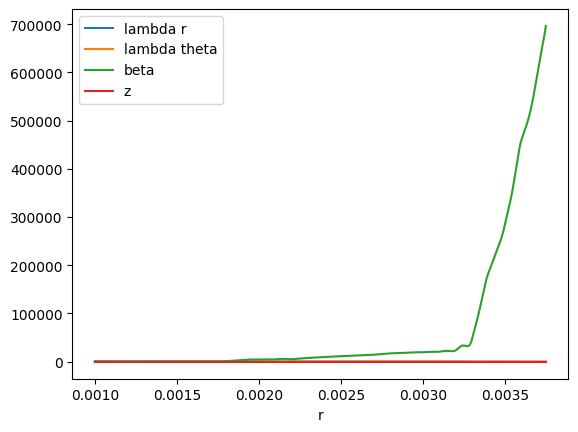

In [99]:
plt.plot(sol.ts, sol.ys[:,0], label="lambda r")
plt.plot(sol.ts, sol.ys[:,1], label="lambda theta")
plt.plot(sol.ts, sol.ys[:,2], label="beta")
plt.plot(sol.ts, (RF-R0)*jnp.cumsum(sol.ys[:,0]*jnp.cos(sol.ys[:,2]))/1000, label="z")
plt.legend()
plt.xlabel('r')
plt.show()

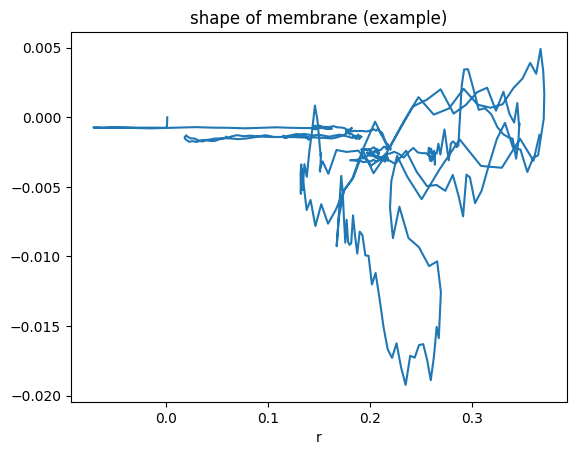

In [100]:
plt.plot((sol.ys[:,1]*sol.ts), -(RF-R0)*jnp.cumsum(sol.ys[:,0]*jnp.cos(sol.ys[:,2]))/1000, label="shape")
plt.title('shape of membrane (example)')
plt.xlabel('r')
plt.show()

In [101]:
# function to compute final height of the membrane
def compute_height(lamb_rs, betas):
    height = (RF-R0) * (lamb_rs * jnp.cos(betas)).mean(-1)
    return height

compute_height(sol.ys[:,0], sol.ys[:,2])

Array(0.00126528, dtype=float32)